# Policy Analysis

## Setup

In [1]:
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(lme4)))
suppressWarnings(suppressMessages(library(VGAM)))
suppressWarnings(suppressMessages(library(boot)))

# import income functions
suppressMessages(source("../../src/income.R"))

select = dplyr::select
theme_set(theme_grey())

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=6, scipen=8)

In [3]:
acs = read_csv("../../data/acs/block_group_census_estimates_wide_wsdot_bins.csv", col_types="dccciiddddddddddddddddddd") %>%
    filter(mean_inc < Inf) %>%
    mutate(fips = fips_code) %>% select(-fips_code)
acs_bins = c(0, 20, 35, 50, 75, 100, 125, 150, 200, Inf)

In [4]:
db_path = "../../../data/hot.db"
trips_raw = load_table(db_path, "trips_linked")
sp_vol = load_table(db_path, "sp_vol")
tolls = load_table(db_path, "tolls")
tt = load_table(db_path, "travel_times")

In [5]:
reliability = suppressMessages(read_csv("../../data/benefits/expected_reliability_savings.csv"))
trip_length_lookup = suppressMessages(read_csv("../../data/milepost_lookups/trip_length_lookup.csv"))
m_est_values = suppressMessages(read_csv("../../data/benefits/est_vot_vor_elast.csv"))

In [6]:
trips.2pct = load_table(db_path, "trips_2pct") %>% 
    select(toll, entry_time, entry=entry_plaza, exit=exit_plaza, is_hov, id, fips, savings) %>%
    execute(col_types="diiiicdd") %>%
    mutate(date_time_1 = as_datetime(as.integer(entry_time/60)*60),
           date_time_5 = as_datetime(as.integer(entry_time/300)*300),
           tod = 100*hour(date_time_5) + minute(date_time_5),
           hour = hour(as_datetime(entry_time)),
           peak = (hour >= 5 & hour < 9) | (hour >= 15 & hour < 19),
           occup_wgt = ifelse(is_hov, ifelse(peak, 3, 2), 1))

In [7]:
m_est_values %>%
    gather(param, est) %>%
    group_by(param) %>%
    group_modify(~ as.data.frame(t(quantile(.$est, c(0.025, 0.5, 0.975)))))

VOT = median(m_est_values$VOT)
VOR = median(m_est_values$VOR)

VOT_low  = quantile(m_est_values$VOT, 0.025)
VOT_high = quantile(m_est_values$VOT, 0.975)
VOR_low  = quantile(m_est_values$VOR, 0.025)
VOR_high = quantile(m_est_values$VOR, 0.975)

param,2.5%,50%,97.5%
<chr>,<dbl>,<dbl>,<dbl>
elasticity,-0.6662101,-0.6360605,-0.606677
VOR,24.0449975,26.4868615,28.923806
VOT,51.9279909,53.1824673,54.359109


In [19]:
trip_counts = trips_raw %>%
    transmute(is_hov = coalesce(is_hov, toll == 0),
              toll = toll) %>%
    group_by(is_hov) %>%
    summarize(trips = n(),
              revenue = sum(toll, na.rm=T)) %>%
    execute

In [20]:
sov_trips = as.numeric(trip_counts[1,2])
hov_trips = as.numeric(trip_counts[2,2])
total_trips = sov_trips + hov_trips
sov_revenue = as.numeric(trip_counts[1,3])
hov_revenue = as.numeric(trip_counts[2,3])
total_revenue = sov_revenue + hov_revenue

In [17]:
calc_by_fips = function(df, HOV=0) {
    df %>%
    filter(!is.na(fips), is_hov == HOV) %>%
    left_join(reliability, by=c("tod", "entry", "exit")) %>%
    left_join(trip_length_lookup, by=c("entry", "exit")) %>%
    select(fips, is_hov, occup_wgt, id, toll, trip_length, savings, reliability) %>%
    group_by(fips) %>%
    summarize(trips = n(),
              users = n_distinct(id),
              revenue = sum(toll),
              vmt = sum(trip_length),
              savings = sum(savings*occup_wgt),
              reliability = sum(reliability*occup_wgt)) %>%
    arrange(fips) %>%
    mutate(savings_benefit = VOT*savings,
           reliability_benefit = VOR*reliability,
           total_benefit = VOT*savings + VOR*reliability,
           net_benefit = total_benefit - revenue) %>%
    inner_join(acs %>%
            select(fips, county, county_name, tract, households, population, mean_inc, contains("race")) %>%
            mutate(tract = paste0("53", county, tract), county=county_name) %>%
            select(-county_name),
        by="fips")
}

## Raising minimum toll

![toll map](toll_map.png)

In [993]:
est_elast_at_min = -0.3394 # copied from `VOT_VOR_estimation`

calc_nb_inc_elast = function(df, min_toll=0.75, max_plaza_nb=0, min_plaza_sb=12) {
    trips_curr = nrow(df)
    
    df = df %>%
        filter(is_hov == 0, toll > 0) %>%
        mutate(group = case_when(
            exit <= max_plaza_nb + 2 & toll <= min_toll ~ "NB_min",
            entry >= min_plaza_sb + 12 & toll <= min_toll ~ "SB_min",
            T ~ "other"
        )) %>%
        group_by(group, toll) %>%
        group_modify(function(.x, .y) {
            if (.y$group == "other") return(mutate(.x, new_toll=.y$toll))
            
            pct_keep = 1 + est_elast_at_min * (min_toll / .y$toll - 1)
            mutate(.x, new_toll=min_toll) %>%
                sample_frac(pct_keep)
        }) %>%
        ungroup %>%
        select(-group, -toll) %>%
        rename(toll=new_toll)
    
    benefits.d = calc_by_fips(df) %>%
        ungroup() %>%
        filter(net_benefit > 0, users > 0) %>%
        mutate(y = log(net_benefit / users),
               x = log(mean_inc/1e6)) %>%
        select(fips, tract, x, y)
    
    m = suppressMessages(suppressWarnings(
            lmer(y ~ x + (1|tract), data=benefits.d, 
                 control=lmerControl(check.nobs.vs.nRE="ignore", 
                                     optCtrl=list(ftol_abs=1e-9, xtol_abs=1e-9)))
        ))
    
    tibble(
        elasticity = coef(summary(m))[2,1],
        revenue = mean(df$toll)*sov_trips,
        volume = sov_trips * nrow(df) / trips_curr,
    )
}

In [1045]:
min_toll_equity = crossing(
    min_toll = seq(0.75, 1.50, 0.25),
    NB = c(0,2,3,4,5,11),
    SB = c(0,4,5,7,8,9,12)
) %>%
#rowwise() %>%
group_by(min_toll, NB, SB) %>%
group_modify(~ calc_nb_inc_elast(trips.2pct, .y$min_toll, .y$NB, .y$SB))

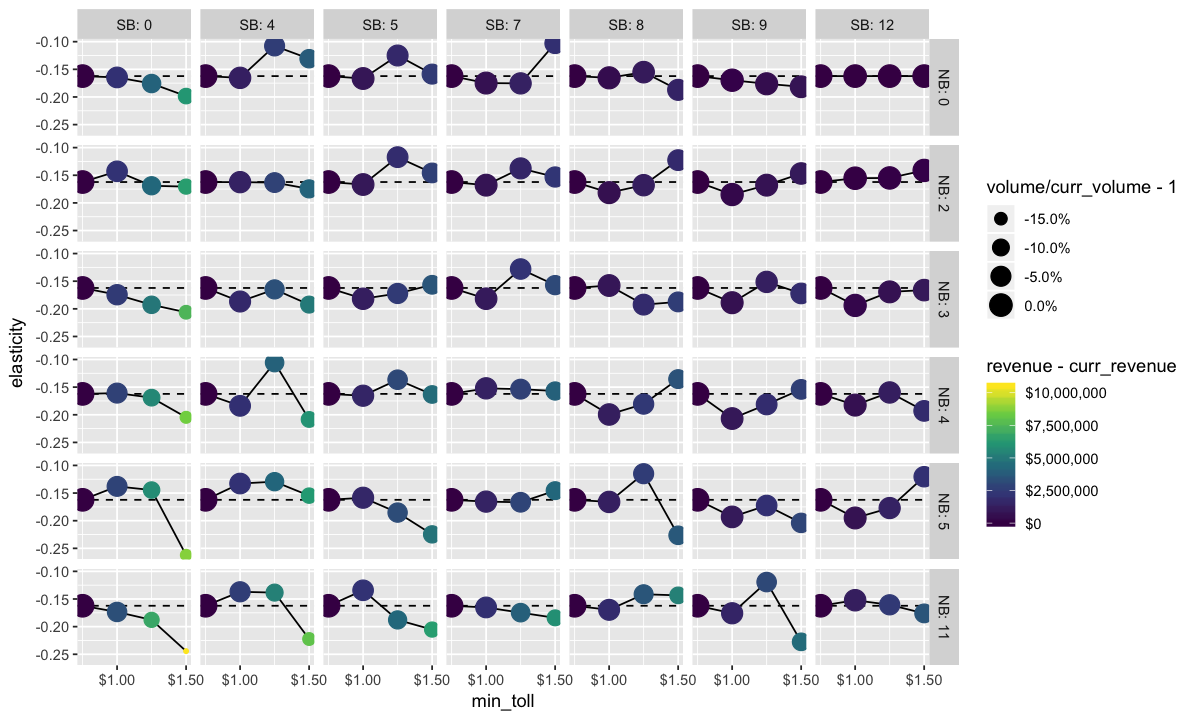

In [1046]:
curr_elast = filter(min_toll_equity, NB==0, SB==12, min_toll==0.75)$elasticity
curr_revenue = filter(min_toll_equity, NB==0, SB==12, min_toll==0.75)$revenue
curr_volume = filter(min_toll_equity, NB==0, SB==12, min_toll==0.75)$volume

ggplot(min_toll_equity, aes(min_toll, elasticity)) + 
    facet_grid(NB ~ SB, labeller=label_both) +
    #facet_wrap("min_toll") +
    geom_hline(yintercept=curr_elast, lty="dashed") +
    geom_line() + 
    geom_point(aes(color=revenue-curr_revenue, size=volume/curr_volume-1)) + 
    scale_color_viridis_c(labels=scales::dollar) +
    scale_size_continuous(labels=scales::percent) +
    scale_x_continuous(labels=scales::dollar, breaks=seq(1, 1.50, 0.50))

In [1048]:
curr_elast

min_toll_equity %>%
    filter((min_toll == 1.00 & NB==3 & SB==12) |
           (min_toll == 1.25 & NB==4 & SB==9) |
           (min_toll == 1.50 & NB==5 & SB==5) |
           (min_toll == 1.00 & NB==11 & SB==0) |
           (min_toll == 1.25 & NB==11 & SB==0) |
           (min_toll == 1.50 & NB==5 & SB==4)) %>%
    mutate(revenue_diff = revenue - curr_revenue,
           revenue_pct = (revenue - curr_revenue)/curr_revenue,
           volume_pct = (volume - curr_volume)/curr_volume) 

[1] -0.1622394

min_toll,NB,SB,elasticity,revenue,volume,revenue_diff,revenue_pct,volume_pct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.00,3,12,-0.1938017,37502522,8576583,372870.9,0.01004240,-0.007166729
1.00,11,0,-0.1734338,40447712,8117109,3318061.2,0.08936419,-0.060355818
1.25,4,9,-0.1813067,38995831,8319880,1866179.8,0.05026117,-0.036882945
1.25,11,0,-0.1877508,43939879,7580271,6810228.3,0.18341752,-0.122500695
1.50,5,4,-0.1546316,43386607,7602978,6256955.9,0.16851642,-0.119872195
1.50,5,5,-0.2247205,41884229,7827729,4754578.0,0.12805340,-0.093854766


---
## Raising maximum toll

In [8]:
toll_sp_vol = tolls %>%
    filter(toll >= 7.50) %>%
    inner_join(sp_vol, tolls, by=c("date_time", "entry")) %>%
    select(date_time, tod, entry, exit, GP_volume, HOT_volume, GP_speed, HOT_speed, toll) %>%
    execute(col_types="iiiiddddd") %>%
    arrange(date_time) %>%
    group_by(entry, exit) %>%
    mutate(toll_lag = lag(toll, order_by=date_time)) %>%
    ungroup %>%
    drop_na() %>%
    sample_n(5e4)

In [9]:
toll.m = vglm(toll ~ toll_lag + GP_volume + GP_speed + HOT_volume + HOT_speed,
         family=tobit(Upper=10), data=filter(toll_sp_vol))

In [499]:
big_tolls = toll_sp_vol %>%
    mutate(fitted = fitted(toll.m))

In [500]:
head(big_tolls)

date_time,tod,entry,exit,GP_volume,HOT_volume,GP_speed,HOT_speed,toll,toll_lag,HOT_vol_p1,HOT_sp_p1,fitted
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>"
1523518200,730,14,17,59.11538,23.38462,33.607201,60.00000,8.000,8.375,26.00000,28.22410,8.627143
1540489800,1750,5,10,49.44898,48.51020,8.497832,36.41007,10.000,10.000,42.82353,60.00000,10.887975
1525157400,650,14,15,48.11538,23.11538,21.867493,60.00000,8.625,8.000,29.93333,25.48566,8.237565
1523259000,730,13,22,53.43636,14.78182,60.000000,60.00000,7.750,7.750,19.80769,60.00000,7.767315
1541489400,730,13,22,54.89091,24.78182,12.598485,36.40186,10.000,10.000,20.53846,16.16573,10.987062
1526543400,750,13,14,49.23636,16.00000,10.664355,60.00000,10.000,10.000,15.73077,10.03065,10.575750


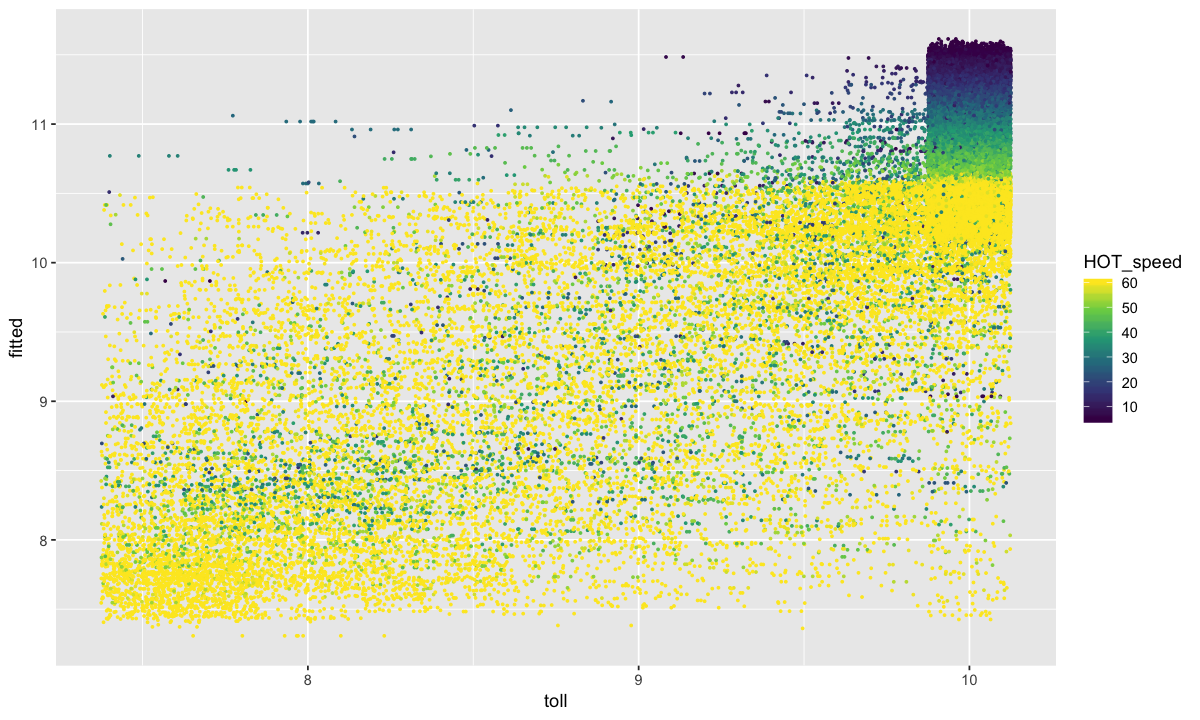

In [918]:
ggplot(big_tolls, aes(toll, fitted, color=HOT_speed)) +
    geom_jitter(width=0.125, height=0, size=0.4)

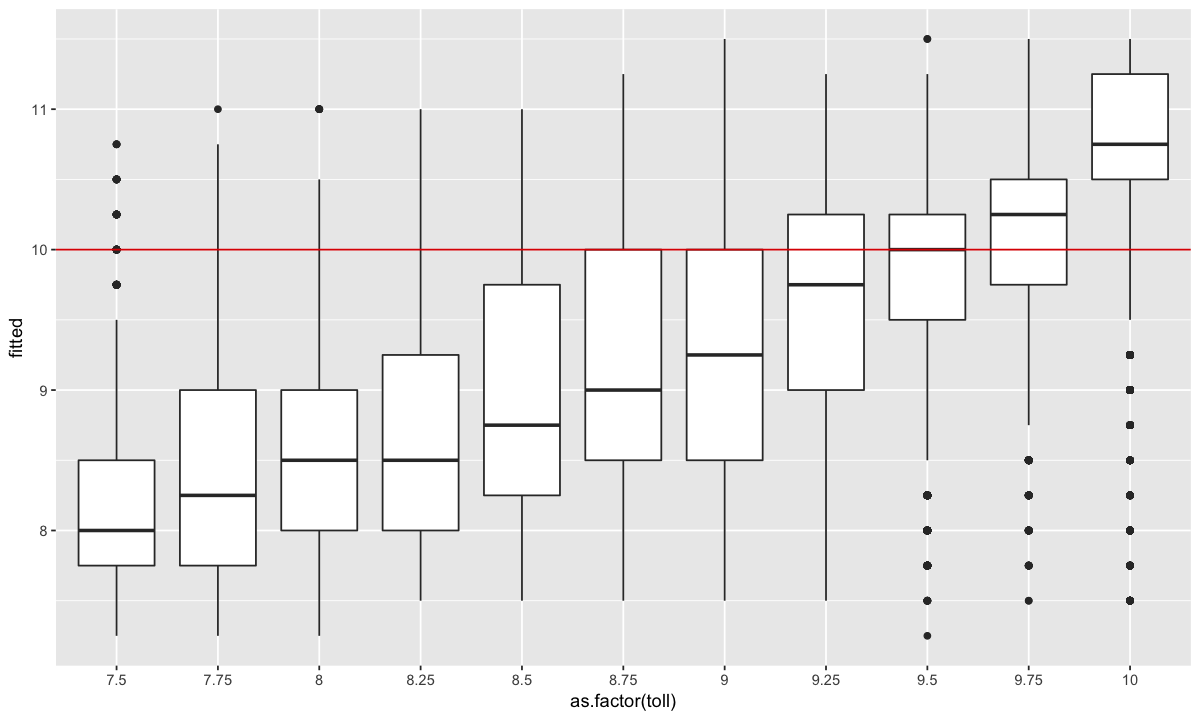

In [502]:
big_tolls %>%
    mutate(toll = round(toll*4)/4,
           fitted = round(fitted*4)/4) %>%
ggplot(aes(as.factor(toll), fitted)) +
    geom_boxplot() +
    geom_hline(yintercept=10, color="#dd0000")

In [503]:
with(big_tolls, table(toll >= 10, fitted >= 10))

       
        FALSE  TRUE
  FALSE 14078  5792
  TRUE   1064 29066

In [10]:
trips_toll = tolls %>%
    inner_join(sp_vol, tolls, by=c("date_time", "entry")) %>%
    select(date_time, tod, entry, exit, GP_volume, HOT_volume, GP_speed, HOT_speed, toll) %>%
    execute(col_types="iiiiddddd") %>%
    arrange(date_time) %>%
    group_by(entry, exit) %>%
    mutate(toll_lag = lag(toll, order_by=date_time)) %>%
    ungroup %>%
    right_join((trips.2pct %>%
        filter(toll >= 9.00) %>%
        transmute(date_time = floor(entry_time/300)*300,
                  entry=entry, exit=exit, billed_toll=toll) %>%
        distinct),
        by=c("date_time", "entry", "exit"))

In [11]:
nrow(trips_toll)
sum(is.na(trips_toll$tod))

[1] 12058

[1] 1789

In [12]:
trips_toll$pred_toll = trips_toll$billed_toll
trips_toll[!is.na(trips_toll$tod),]$pred_toll = round(predict(toll.m, newdata=trips_toll)[,1] * 4)/4

ERROR: Error in predict(toll.m, newdata = trips_toll): object 'toll.m' not found


In [13]:
trips.2pct = trips.2pct %>%
    mutate(dttm5 = as.numeric(date_time_5)) %>%
    select(-contains("pred_toll"), -contains("_speed")) %>%
    left_join(select(trips_toll, date_time, entry, exit, GP_speed, HOT_speed, pred_toll), 
             by=c("dttm5"="date_time", "entry", "exit")) %>%
    select(-dttm5)

In [14]:
# function to estimate the toll if the cap were raised to `max_toll`
resp_curve = function(toll, HOT_speed, max_toll=15) {
    case_when(
        HOT_speed < 45 ~ max_toll,
        HOT_speed < 60 ~ toll + (max_toll - toll)*(60-HOT_speed)/15,
        T ~ toll
    )
}

In [50]:
est_elast_at_max = -0.64 # copied from `VOT_VOR_estimation`
#est_elast_at_max = -1.2

calc_nb_inc_elast = function(df, max_toll=10.00, fix_above=Inf) {
    trips_curr = sum(df$is_hov == 0)
    
    df = df %>%
        filter(is_hov == 0, toll > 0) %>%
        mutate(group = if_else(toll < fix_above, "other", "change")) %>%
        group_by(group, toll) %>%
        group_modify(function(.x, .y) {
            if (.y$group == "other") 
                return(mutate(.x, new_toll=.y$toll, new_savings=savings))
            
            #pred_toll = if_else(.x$pred_toll == .y$toll, .x$pred_toll, .x$pred_toll*2)
            #new_toll = pmax(.y$toll, pmin(pred_toll, max_toll))
            new_toll = resp_curve(.y$toll, .x$HOT_speed, max_toll)
            #new_toll = (.y$toll-0.75)*(max_toll/10) + 0.75 
            pct_keep = 1 + est_elast_at_max * (new_toll / .y$toll - 1)
            pct_keep = pmax(pct_keep, 0)
            keep = rbinom(length(pct_keep), 1, pct_keep)
            
            if (.y$group == "other") 
                new_savings = .x$savings
            else
                new_savings = .x$savings * pmax(1, 45/coalesce(.x$HOT_speed, 45))
                
            mutate(.x, new_toll=new_toll, new_savings=new_savings) %>%
                filter(keep==1)
        }) %>%
        ungroup %>%
        select(-group, -toll, -savings) %>%
        rename(toll=new_toll, savings=new_savings)
    
    benefits.d = calc_by_fips(df) %>%
        ungroup() %>%
        filter(net_benefit > 0, trips >= 0) %>%
        mutate(y = log(net_benefit / trips),
               x = log(mean_inc/1e6)) %>%
        select(fips, tract, x, y)
    
    m = suppressMessages(suppressWarnings(
            lmer(y ~ x + (1|tract), data=benefits.d, 
                 control=lmerControl(check.nobs.vs.nRE="ignore",
                                     optCtrl=list(ftol_abs=1e-9, xtol_abs=1e-9)))
        ))
    
    tibble(
        elasticity = coef(summary(m))[2,1],
        revenue = mean(df$toll)*sov_trips,
        volume = total_trips * nrow(df) / trips_curr,
    )
}

In [59]:
max_toll_equity = crossing(
    max_toll = seq(10, 20, 1),
) %>%
group_by(max_toll) %>%
group_modify(~ calc_nb_inc_elast(trips.2pct, .y$max_toll, 10.00))

In [60]:
curr_elast = max_toll_equity[1,]$elasticity
curr_revenue = max_toll_equity[1,]$revenue
curr_volume = max_toll_equity[1,]$volume

max_toll_equity = max_toll_equity %>%
    mutate(revenue_diff = revenue - curr_revenue,
           revenue_pct = (revenue - curr_revenue)/curr_revenue,
           elast_pct = (elasticity - curr_elast)/curr_elast,
           volume_pct = (volume - curr_volume)/curr_volume) 

In [61]:
max_toll_equity %>%
    mutate_at(vars(contains("_pct")), scales::percent)

max_toll,elasticity,revenue,volume,revenue_diff,revenue_pct,elast_pct,volume_pct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
10,-0.2102298,30987225,16937221,0.00,0%,0%,0%
11,-0.2078042,31092795,16914985,105570.28,0.341%,-1.15%,-0.131%
12,-0.2024113,31167772,16892461,180547.00,0.583%,-3.72%,-0.264%
13,-0.2047505,31241873,16874059,254648.09,0.822%,-2.61%,-0.373%
14,-0.2038643,31282819,16854699,295594.07,0.954%,-3.03%,-0.487%
15,-0.2006423,31250350,16829683,263124.57,0.849%,-4.56%,-0.635%
16,-0.2018976,31233107,16810131,245881.72,0.793%,-3.96%,-0.750%
17,-0.1930852,31125160,16783678,137935.12,0.445%,-8.16%,-0.907%
18,-0.2004369,31000404,16759716,13178.94,0.0425%,-4.66%,-1.05%


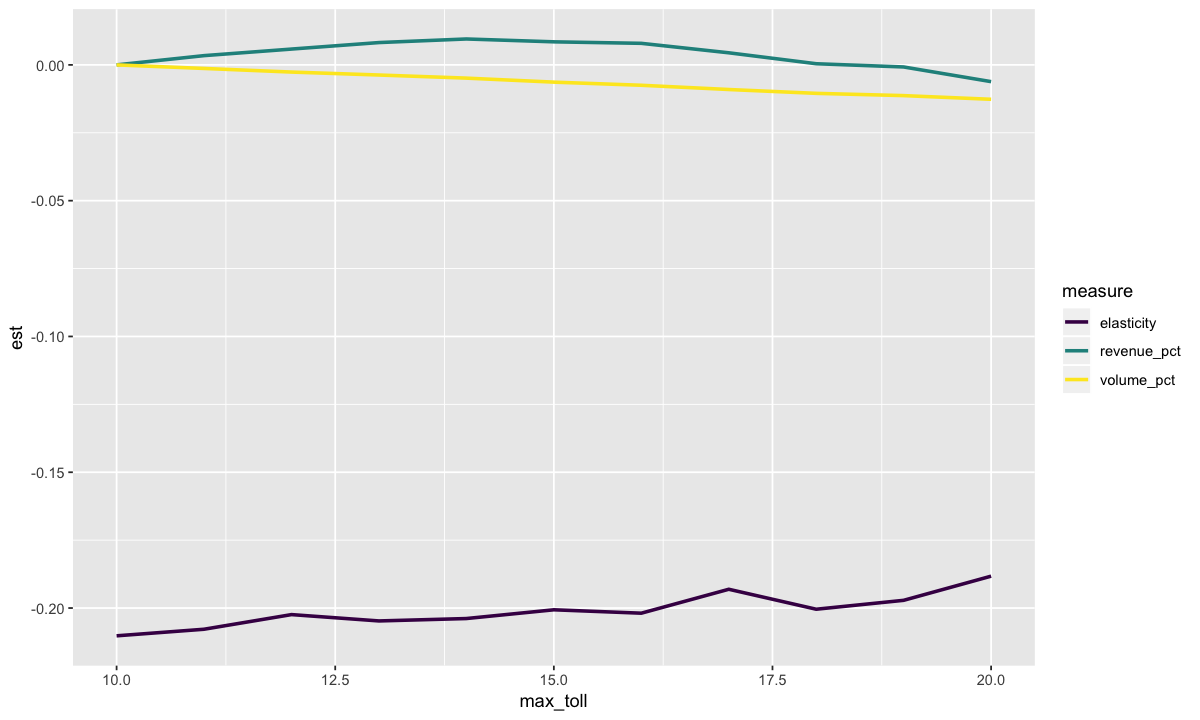

In [62]:
max_toll_equity %>%
    select(max_toll, elasticity, revenue_pct, volume_pct) %>%
    gather(measure, est, -max_toll) %>%
ggplot(aes(max_toll, est, color=measure)) + 
    geom_line(lwd=1) +
    scale_color_viridis_d()

In [989]:
head(trips.2pct)

toll,entry_time,entry,exit,is_hov,id,fips,savings,date_time_1,date_time_5,tod,hour,peak,occup_wgt,HOT_speed.x,GP_speed,HOT_speed.y,pred_toll
<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.75,1514878872,5,5,0,4718396806487642257,530330093002,0.00000000,2018-01-02 07:41:00,2018-01-02 07:40:00,740,7,TRUE,1,NA,NA,NA,NA
0.75,1514875917,4,7,0,-7228328777495153646,530610413042,0.00000000,2018-01-02 06:51:00,2018-01-02 06:50:00,650,6,TRUE,1,NA,NA,NA,NA
0.75,1514880965,16,23,0,6765682015448136632,530330218021,0.03577778,2018-01-02 08:16:00,2018-01-02 08:15:00,815,8,TRUE,1,NA,NA,NA,NA
0.75,1514878538,16,17,0,-9189267815259293727,530330220052,0.01750000,2018-01-02 07:35:00,2018-01-02 07:35:00,735,7,TRUE,1,NA,NA,NA,NA
0.00,1514878566,14,17,1,NA,NA,0.20761111,2018-01-02 07:36:00,2018-01-02 07:35:00,735,7,TRUE,3,NA,NA,NA,NA
0.75,1514906339,5,12,0,-79136306211544349,530610520041,0.02405556,2018-01-02 15:18:00,2018-01-02 15:15:00,1515,15,TRUE,1,NA,NA,NA,NA


Warning message:
“Removed 70 rows containing missing values (geom_path).”Warning message:
“Removed 70 rows containing missing values (geom_path).”

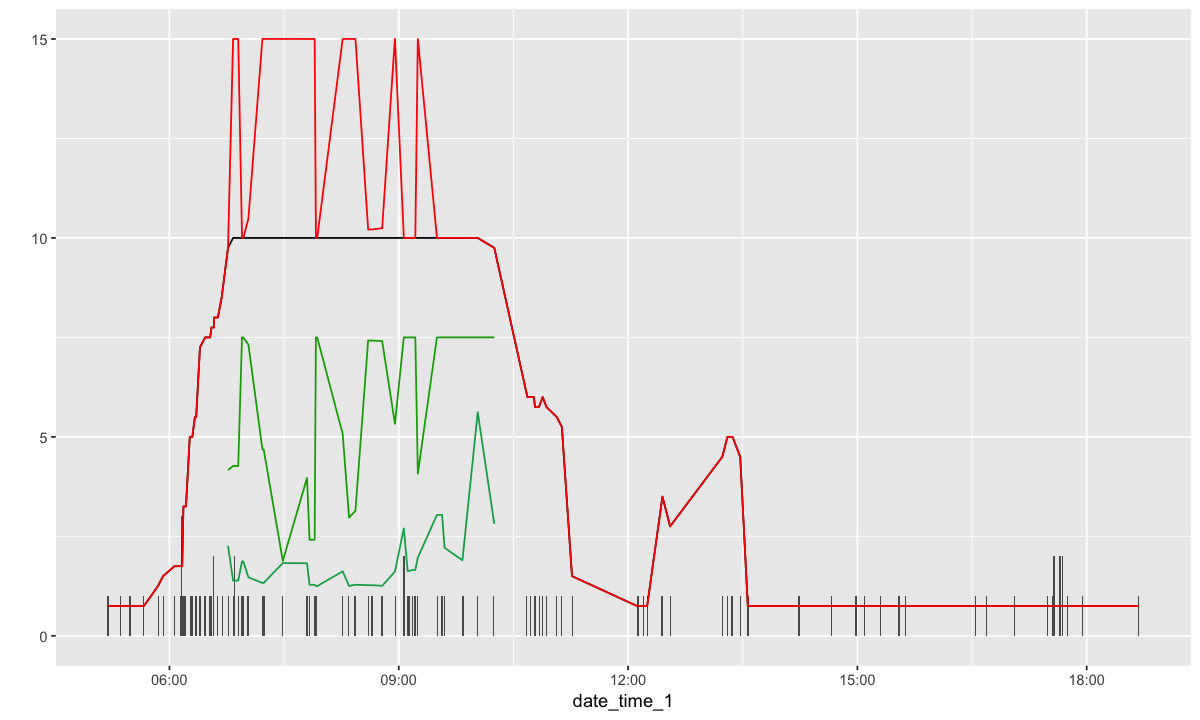

In [1038]:
trips.2pct %>%
    filter(is_hov == 0, toll > 0) %>%
    mutate(group = if_else(toll < 10, "other", "change")) %>%
    group_by(group, toll) %>%
    group_modify(function(.x, .y) {
        if (.y$group == "other") 
            return(mutate(.x, new_toll=.y$toll, new_savings=savings))

        #pred_toll = if_else(.x$pred_toll == .y$toll, .x$pred_toll, .x$pred_toll*2)
        #new_toll = pmax(.y$toll, pmin(pred_toll, max_toll))
        new_toll = resp_curve(.y$toll, .x$HOT_speed, 15)
        #new_toll = (.y$toll-0.75)*(15/10) + 0.75 
        pct_keep = 1 + est_elast_at_max * (new_toll / .y$toll - 1)
        pct_keep = pmax(pct_keep, 0)
        keep = rbinom(length(pct_keep), 1, pct_keep)

        if (.y$group == "other") 
            new_savings = .x$savings
        else
            new_savings = .x$savings * pmax(1, 45/coalesce(.x$HOT_speed, 45))

        mutate(.x, new_toll=new_toll, new_savings=new_savings) %>%
            filter(keep==1)
    }) %>%
    ungroup %>%
    filter(entry == 13) %>% 
    filter(date(date_time_1) == "2018-06-25") %>%
    arrange(entry_time) %>%
    #group_by(date(date_time_1)) %>% 
    #summarize(pctmax= mean(toll == 10), n=n()) %>%
    #arrange(pctmax)
    #qplot(date_time_1, savings, data=., geom="line")
    qplot(date_time_1, data=., bins=(19-5)*60) + 
        geom_line(aes(y=HOT_speed/8), color="#00aa00") +
        geom_line(aes(y=GP_speed/4), color="#00aa55") +
        geom_line(aes(y=toll)) +
        geom_line(aes(y=new_toll), color="red")

In [967]:
head(trips.2pct)

toll,entry_time,entry,exit,is_hov,id,fips,savings,date_time_1,date_time_5,tod,hour,peak,occup_wgt,HOT_speed,pred_toll
<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>
0.75,1514878872,5,5,0,4718396806487642257,530330093002,0.00000000,2018-01-02 07:41:00,2018-01-02 07:40:00,740,7,TRUE,1,NA,NA
0.75,1514875917,4,7,0,-7228328777495153646,530610413042,0.00000000,2018-01-02 06:51:00,2018-01-02 06:50:00,650,6,TRUE,1,NA,NA
0.75,1514880965,16,23,0,6765682015448136632,530330218021,0.03577778,2018-01-02 08:16:00,2018-01-02 08:15:00,815,8,TRUE,1,NA,NA
0.75,1514878538,16,17,0,-9189267815259293727,530330220052,0.01750000,2018-01-02 07:35:00,2018-01-02 07:35:00,735,7,TRUE,1,NA,NA
0.00,1514878566,14,17,1,NA,NA,0.20761111,2018-01-02 07:36:00,2018-01-02 07:35:00,735,7,TRUE,3,NA,NA
0.75,1514906339,5,12,0,-79136306211544349,530610520041,0.02405556,2018-01-02 15:18:00,2018-01-02 15:15:00,1515,15,TRUE,1,NA,NA
